# Importing Data![text-summarizer-output.png](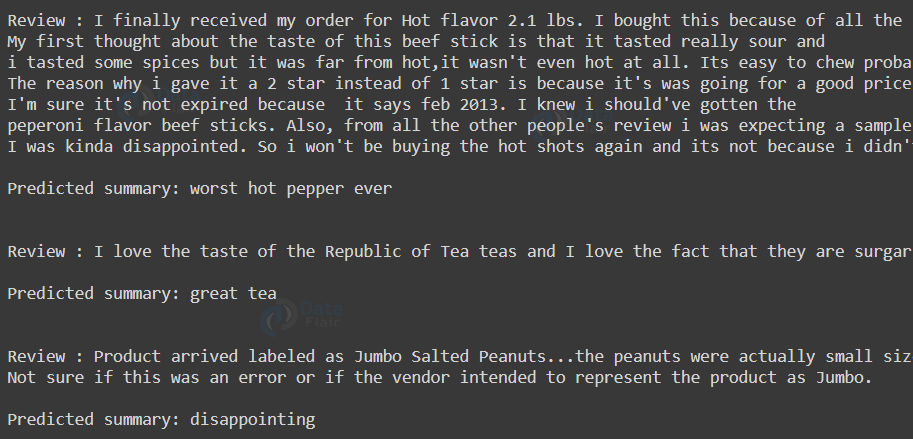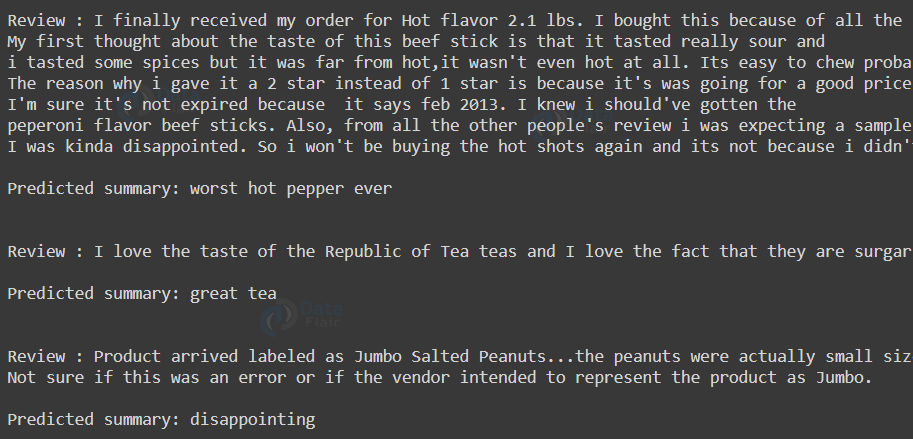)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/gdrive/My Drive/Data Mining/Reviews.csv")

In [ ]:
df.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...
568453,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,5,1338422400,Great Honey,"I am very satisfied ,product is as advertised,..."


# Install Tensorflow

In [ ]:
!pip install tensorflow

# Import Libraries

In [ ]:
#DataFlair Project
#import all the required libraries
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data Selection
Use only text and summary columns

In [ ]:
input_data = df.loc[:,'Text']
target_data = df.loc[:,'Summary']
target_data.replace('', np.nan, inplace=True)

In [ ]:
input_data

0         I have bought several of the Vitality canned d...
1         Product arrived labeled as Jumbo Salted Peanut...
2         This is a confection that has been around a fe...
3         If you are looking for the secret ingredient i...
4         Great taffy at a great price.  There was a wid...
                                ...                        
568449    Great for sesame chicken..this is a good if no...
568450    I'm disappointed with the flavor. The chocolat...
568451    These stars are small, so you can give 10-15 o...
568452    These are the BEST treats for training and rew...
568453    I am very satisfied ,product is as advertised,...
Name: Text, Length: 568454, dtype: object

In [ ]:
target_data

0                      Good Quality Dog Food
1                          Not as Advertised
2                      "Delight" says it all
3                             Cough Medicine
4                                Great taffy
                         ...                
568449                   Will not do without
568450                          disappointed
568451              Perfect for our maltipoo
568452    Favorite Training and reward treat
568453                           Great Honey
Name: Summary, Length: 568454, dtype: object

# Preprocessing

Note: the pickle file contains a dictionary named contractions. This dictionary maps contracted forms of words and phrases commonly used in English to their expanded equivalents. For instance, it includes entries like:

    "ain't" mapped to "is not"
    "can't" mapped to "cannot"
    "I'm" mapped to "I am"
    "you've" mapped to "you have"

In [ ]:
input_texts=[]
target_texts=[]
input_words=[]
target_words=[]
contractions=pickle.load(open("/content/gdrive/My Drive/Data Mining/contractions.pkl","rb"))['contractions']
#initialize stop words and LancasterStemmer
stop_words=set(stopwords.words('english'))
stemm=LancasterStemmer()

 Perform text cleaning


* Remove HTML Tags: It uses BeautifulSoup with the "lxml" parser to remove HTML tags from the input text.
* Tokenization: The word_tokenize function from the NLTK library is used to split the cleaned text into individual words or tokens.
* Filter Only Alphabetical Words: This step filters out tokens to keep only those that are entirely alphabetic, removing any numbers or special characters.
* Expand Contractions: Utilizing the contractions dictionary loaded previously, this step expands shortened words (like "can't" to "cannot", "I'm" to "I am") to their full forms.
* Stemming and Removing Stop Words: Depending on the src parameter, if it equals "inputs", the function applies stemming to the words, reducing them to their root forms using a stemming algorithm (implied by stemm.stem(w)).



In [ ]:
def clean(texts,src):
  #remove the html tags
  texts = BeautifulSoup(texts, "lxml").text
  #tokenize the text into words
  words=word_tokenize(texts.lower())
  #filter words which contains \
  #integers or their length is less than or equal to 3
  # words= list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
  #keep only alphabet
  words= list(filter(lambda w:(w.isalpha()),words))
  #contraction file to expand shortened words
  words= [contractions[w] if w in contractions else w for w in words ]
  #stem the words to their root word and filter stop words
  if src=="inputs":
    words= [stemm.stem(w) for w in words if w not in stop_words]
  else:
    words= [w for w in words if w not in stop_words]
  return words

Sequence marking: adding "sos" at the start of the sentence and "eos" at the end of the sentence.

In [ ]:
#pass the input records and taret records
for in_txt,tr_txt in zip(input_data,target_data):
  in_words= clean(in_txt,"inputs")
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  #add 'sos' at start and 'eos' at end of text
  tr_words= clean("sos "+str(tr_txt)+" eos","target")
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words

<ipython-input-10-8a37be58eac6>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  texts = BeautifulSoup(texts, "lxml").text


Seeing the number of words in input and target. Also seeing the maximum length for input and target.

In [ ]:
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words

#get the length of the input and target texts which appears most often
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])

print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  76105
number of target words :  31837
maximum input length :  64
maximum target length :  17


In [ ]:
len(input_texts)

568454

In [ ]:
len(target_texts)

568454

# Splitting

In [ ]:
#split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0)

# Tokenizing
Tokenize word into integer sequence using vectorization technique

For example,

`L = [ ‘what doing’, ‘how are you’, ’good ’]`

Tokenize all the elements of list ‘L’ and make a dictionary having key as tokens and value as the counter number. So after the data is fit we get a dictionary as

`D = { ‘what’ : 1 , ‘doing’ :2 , ‘how’ : 3 , ‘are’ : 4 , ‘you’ :5 , ‘good’ : 6 }`

So we have fit our data, now let’s transform the below list ‘J’ into integer sequence using our tokenizer.

`J = [ ‘what are you doing’, ‘you are good’ ]`

Transformed (Vectorized) J : [ [ 1 , 4 , 5 , 2 ] , [ 5 , 4 , 6 ] ]

In [ ]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)

#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train)
y_train= tr_tokenizer.texts_to_sequences(y_train)

* Padding Sequences:
pad_sequences is used to ensure that all sequences in x_train (input data) and y_train (target data) are of uniform length.
For x_train, this length is max_in_len, and for y_train, it's max_tr_len. If any sequence is shorter than these lengths, zeros are added to the end of the sequence (due to padding='post'), making them all uniformly long.
* Preparing Decoder Input and Target Data:
  * Decoder Input Data (dec_in_data): This is created by taking all elements of dec_data except the last one ([:,:-1]). By removing the last element, it is ensured that the decoder input data won't include the 'eos' (end of sequence) token. Removing 'eos' from the Decoder Input Data allows the model to focus on the sequence being generated without the presence of the end token. This simulates a situation where the decoder is in the process of generating a sequence and has not reached its end. When attempting to generate a new sequence, 'eos' is not needed because the main goal is to produce a sensible and cohesive sequence, rather than marking the end of an existing sequence.

  * Decoder Target Data (dec_tr_data):
    * Reshaping dec_data: Reshaping is often necessary to ensure compatibility with certain neural network architectures
    * Skipping the first element: By slicing the array to skip the first element ([:,1:]), the 'sos' (start of sequence) token is effectively removed from the beginning of each sequence. This is done because during training, we want the model to predict the next word given the current and all previous words. Including the 'sos' token as part of the target data would result in the model trying to predict the first word of the sequence, which is unnecessary.


In [ ]:
#pad array of 0's if the length is less than the maximum length
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post')
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')

#decoder input data will not include the last word
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

# Training using Model (LSTM)

* `K.clear_session()`: This means getting rid of any leftover stuff from previous projects (models) you were working on.
* `latent_dim` variable, particularly when setting up an embedding layer, specifies the dimensionality of the embedding space. This is a technical way of defining how many features or properties each word (or input token) will be represented by after being processed through the embedding layer. In this case, the latent_dim is set to 500, each word in your vocabulary will be converted into a vector of 500 numerical values. These values are learned during the training process and are meant to capture semantic properties, relationships, and other linguistic patterns of words.
* `en_inputs = Input(shape=(max_in_len,))` initializes the input layer for the encoder part of the model. This layer accepts input sequences where each sequence has a length defined by max_in_len.
* `en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs)` adds an embedding layer immediately after the input layer. The embedding layer is designed to convert integer representations of words into dense vectors of fixed size. `latent_dim` is 500, every word is turned into a list of 500 numbers.

In [ ]:
K.clear_session()
latent_dim = 500

#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,))
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs)

Building 3-stacked layer of LSTM
The `return_sequences=True parameter` tells this layer to output a sequence of vectors (one for each time step in the input), which is necessary because we want the next LSTM layer to receive these sequences as its input. The `return_state=True` parameter means that, in addition to the sequence of vectors, this layer will also output its final hidden state (state_h1) and cell state (state_c1). These states capture information learned from the input sequence up to that point.

In [ ]:
#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True)
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding)

#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True)
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1)

#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)

#encoder states
en_states= [state_h3, state_c3]

* `dec_inputs` is a setting up an entry point for the decoder, not specifying what the summaries will say, but getting ready to make them.
*  `Embedding layer`, a tool that turns the words of your summaries into a form that the model can work with more easily (list of numbers).
* `dec_lstm` is where the actual process of creating summaries takes place.
* The decoder's LSTM works through the summary it's creating, adding one word at a time, and outputs a sequence of word lists that represent the final summary.

In [ ]:
# Decoder.
dec_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_tr_words+1, latent_dim)
dec_embedding = dec_emb_layer(dec_inputs)

#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states)

* The Attention layer is like a focus mechanism. It helps the decoder pay special attention to certain parts of the input text while it's generating the summary.
* Once the model have the focused information from the Attention layer (attn_out), the model combine it with the decoder's original output (dec_outputs)

In [ ]:
#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])

#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

* This is like the final decision-maker of the decoder. It looks at all the information the decoder has gathered, with a bit of extra focus from the Attention layer, and then decides the next words for the summary.
* Softmax Activation: This part helps the decision-maker (Dense layer) by turning its decisions into probabilities.
* It has `num_tr_words+1` units, which means it's designed to predict which word comes next in the summary by considering the entire vocabulary of target words (plus one for potential padding or an end-of-sequence marker).

In [ ]:
#Dense layer (output layer)
dec_dense = Dense(num_tr_words+1, activation='softmax')
dec_outputs = dec_dense(merge)

Training and Viewing Model Structure

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 500)              3805300   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 64, 500),            2002000   ['embedding[0][0]']           
                              (None, 500),                                                        
                              (None, 500)]                                                    

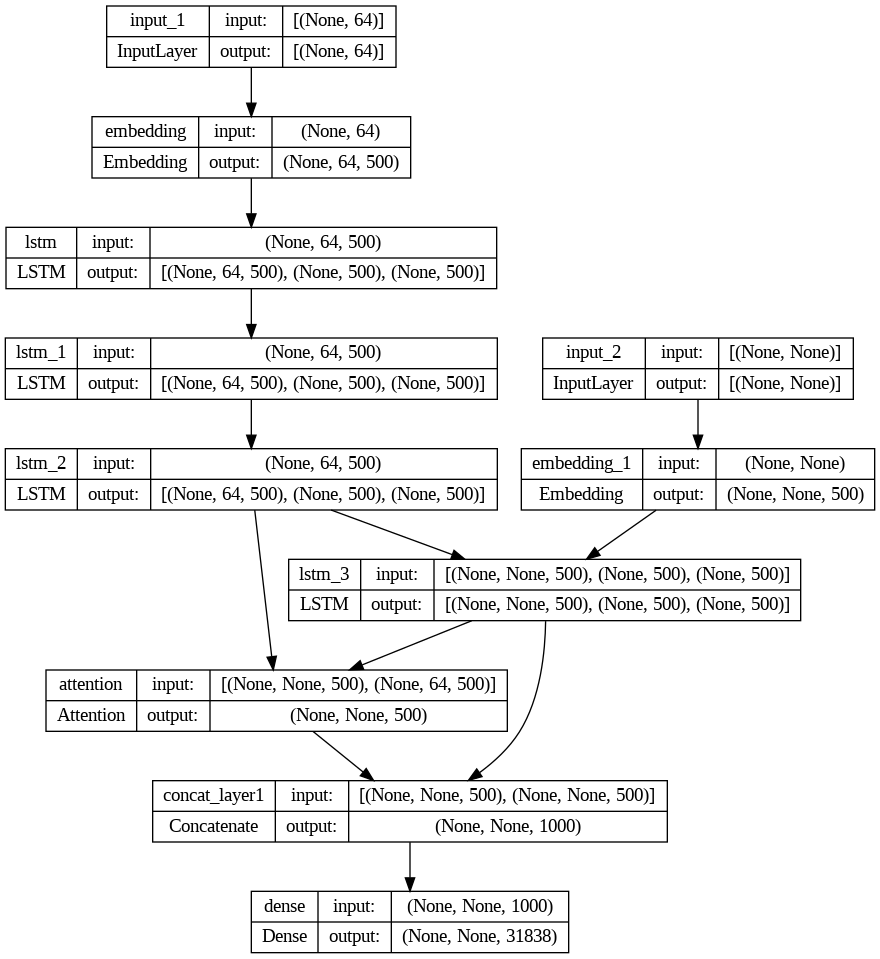

In [ ]:
#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
model.fit(
    [en_in_data, dec_in_data],
    dec_tr_data,
    batch_size=512,
    epochs=10,
    validation_split=0.1,
    )

#Save model
model.save("s2s")

Epoch 1/10
800/800 [==============================] - 844s 1s/step - loss: 1.4271 - accuracy: 0.8180 - val_loss: 1.3207 - val_accuracy: 0.8304
Epoch 2/10
800/800 [==============================] - 848s 1s/step - loss: 1.2922 - accuracy: 0.8305 - val_loss: 1.2744 - val_accuracy: 0.8288
Epoch 3/10
800/800 [==============================] - 848s 1s/step - loss: 1.2536 - accuracy: 0.8314 - val_loss: 1.2437 - val_accuracy: 0.8324
Epoch 4/10
800/800 [==============================] - 848s 1s/step - loss: 1.2343 - accuracy: 0.8323 - val_loss: 1.2304 - val_accuracy: 0.8325
Epoch 5/10
800/800 [==============================] - 848s 1s/step - loss: 1.2170 - accuracy: 0.8329 - val_loss: 1.2141 - val_accuracy: 0.8330
Epoch 6/10
800/800 [==============================] - 848s 1s/step - loss: 1.1919 - accuracy: 0.8337 - val_loss: 1.1885 - val_accuracy: 0.8342
Epoch 7/10
800/800 [==============================] - 843s 1s/step - loss: 1.1617 - accuracy: 0.8355 - val_loss: 1.1645 - val_accuracy: 0.8345

Inference model

In [ ]:
# encoder inference
latent_dim=500
#/content/gdrive/MyDrive/Text Summarizer/
#load the model
model = models.load_model("s2s")

#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

In [ ]:
# decoder inference
#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))

# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)

#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

# Handling custom input

Attention Inference

In [ ]:
#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])

merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

In [ ]:
#Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)

# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

In [ ]:
#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index
reverse_target_word_index[0]=' '

def decode_sequence(input_seq):
    #get the encoder output and states by passing the input sequence
    en_out, en_h, en_c= en_model.predict(input_seq)

    #target sequence with initial word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']

    #if the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    #append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition:
        #get predicted output, hidden and cell state.
        output_words, dec_h, dec_c= dec_model.predict([target_seq] + [en_out,en_h, en_c])

        #get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word +" "
        # Exit condition: either hit max length
        # or find a stop word or last word.
        if text_word == "eos" or len(decoded_sentence) > max_tr_len:
          stop_condition = True
      #update target sequence to the current word index.
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word_index
    en_h, en_c = dec_h, dec_c
    #return the decoded sentence
    return decoded_sentence

In [ ]:
inp_review = "This is definitely one of my go-to treats when I need a sweet fix. I was pleasantly surprised by how well-balanced the flavors were"
print("Review :",inp_review)
inp_review = clean(inp_review,"inputs")
inp_review = ' '.join(inp_review)
inp_x= in_tokenizer.texts_to_sequences([inp_review])
inp_x= pad_sequences(inp_x,  maxlen=max_in_len, padding='post')

summary=decode_sequence(inp_x.reshape(1,max_in_len))
if 'eos' in summary :
  summary=summary.replace('eos','')
print("\nPredicted summary:",summary);print("\n")

Review : This is definitely one of my go-to treats when I need a sweet fix. I was pleasantly surprised by how well-balanced the flavors were
1/1 [==============================] - 0s 20ms/step

Predicted summary: great great great 




In [ ]:
inp_review = "Unfortunately, it was too sweet for my taste, almost cloying. The texture was a bit off-putting, not what I was expecting at all."
print("Review :",inp_review)
inp_review = clean(inp_review,"inputs")
inp_review = ' '.join(inp_review)
inp_x= in_tokenizer.texts_to_sequences([inp_review])
inp_x= pad_sequences(inp_x,  maxlen=max_in_len, padding='post')

summary=decode_sequence(inp_x.reshape(1,max_in_len))
if 'eos' in summary :
  summary=summary.replace('eos','')
print("\nPredicted summary:",summary);print("\n")

Review : Unfortunately, it was too sweet for my taste, almost cloying. The texture was a bit off-putting, not what I was expecting at all.
1/1 [==============================] - 0s 21ms/step

Predicted summary: good good good good 




From the code owner

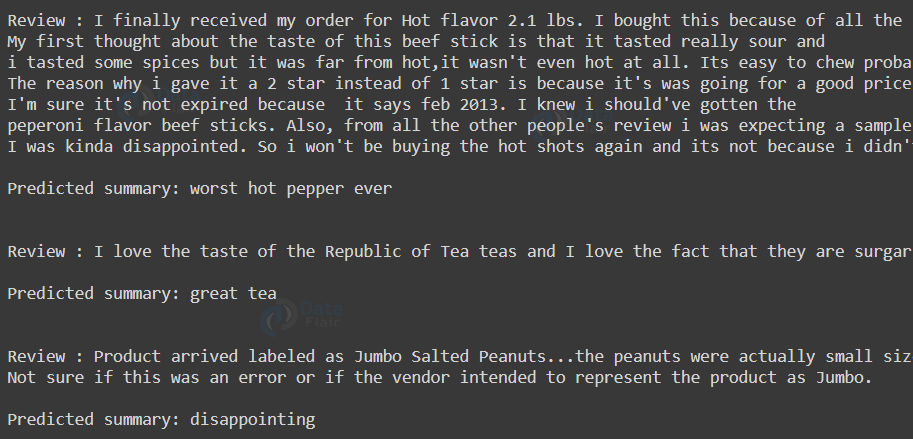